In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb

import shap

# Open University Learning Analytics dataset

## Dataset Descriptions

### courses.csv

- Contains the list of all available modules and their presentations.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| code_module           | Code name of the module, serving as the identifier.      |
| code_presentation     | Code name of the presentation (year + B or J).           |
| length                | Length of the module-presentation in days.               |

### assessments.csv

- Contains information about assessments in module-presentations.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| code_module           | Identification code of the module.                      |
| code_presentation     | Identification code of the presentation.                |
| id_assessment         | Identification number of the assessment.                |
| assessment_type       | Type of assessment (TMA, CMA, Exam).                     |
| date                  | Final submission date of the assessment.                |
| weight                | Weight of the assessment in percentage.                 |

### vle.csv

- Contains information about available materials in the VLE.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| id_site               | Identification number of the material.                   |
| code_module           | Identification code for the module.                      |
| code_presentation     | Identification code of the presentation.                |
| activity_type         | The role associated with the module material.            |
| week_from             | Week from which the material is planned to be used.     |
| week_to               | Week until which the material is planned to be used.    |

### studentInfo.csv

- Contains demographic information about the students together with their results.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| code_module           | Identification code for the module.                      |
| code_presentation     | Identification code of the presentation.                |
| id_student            | Unique identification number for the student.           |
| gender                | Student's gender.                                       |
| region                | Geographic region where the student lived.              |
| highest_education     | Highest education level on entry.                       |
| imd_band              | Index of Multiple Deprivation band.                     |
| age_band              | Band of the student's age.                              |
| num_of_prev_attempts  | Number of times the student has attempted the module.    |
| studied_credits       | Total number of credits for the modules the student is studying. |
| disability            | Indicates whether the student has declared a disability. |
| final_result          | Student's final result in the module-presentation.       |

### studentRegistration.csv

- Contains information about the time when the student registered for the module presentation.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| code_module           | Identification code for a module.                        |
| code_presentation     | Identification code of the presentation.                |
| id_student            | Unique identification number for the student.           |
| date_registration     | Date of student's registration relative to the start of the module-presentation. |
| date_unregistration   | Date of student's unregistration relative to the start of the module-presentation. (Empty for completed courses) |

### studentAssessment.csv

- Contains the results of students' assessments.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| id_assessment         | Identification number of the assessment.                |
| id_student            | Unique identification number for the student.           |
| date_submitted        | Date of student submission, measured as the number of days since the start of the module presentation. |
| is_banked             | A status flag indicating that the assessment result has been transferred from a previous presentation. |
| score                 | The student's score in this assessment.                  |

### studentVle.csv

- Contains information about each student's interactions with the materials in the VLE.

| Column                | Description                                             |
|-----------------------|---------------------------------------------------------|
| code_module           | Identification code for a module.                        |
| code_presentation     | Identification code of the module presentation.          |
| id_student            | Unique identification number for the student.           |
| id_site               | Identification number for the VLE material.             |
| date                  | Date of student's interaction with the material, measured as the number of days since the start of the module-presentation. |
| sum_click             | The number of times a student interacts with the material in that day. |


 It contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules). Presentations of courses start in February and October - they are marked by “B” and “J” respectively. The dataset consists of tables connected using unique identifiers. All tables are stored in the csv format.

In [5]:
# Will only need studentAssesment and studentInfo
oulad_studInf_df = pd.read_csv('studentInfo.csv')
oulad_studAssess_df = pd.read_csv('studentAssessment.csv')

In [6]:
oulad_studAssess_df

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [7]:
oulad_studInf_df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


# Basic EDA on Data

In [8]:
oulad_studInf_df.describe().loc[:, ['num_of_prev_attempts', 'studied_credits']]

,num_of_prev_attempts,studied_credits
count,32593.000000,32593.000000
mean,0.163225,79.758691
std,0.479758,41.071900
min,0.000000,30.000000
25%,0.000000,60.000000
50%,0.000000,60.000000
75%,0.000000,120.000000
max,6.000000,655.000000


In [9]:
oulad_studAssess_df.describe().loc[:, ['date_submitted', 'is_banked', 'score']]

,date_submitted,is_banked,score
count,173912.000000,173912.000000,173739.000000
mean,116.032942,0.010977,75.799573
std,71.484148,0.104194,18.798107
min,-11.000000,0.000000,0.000000
25%,51.000000,0.000000,65.000000
50%,116.000000,0.000000,80.000000
75%,173.000000,0.000000,90.000000
max,608.000000,1.000000,100.000000


## Gender performance in terms of passing modules

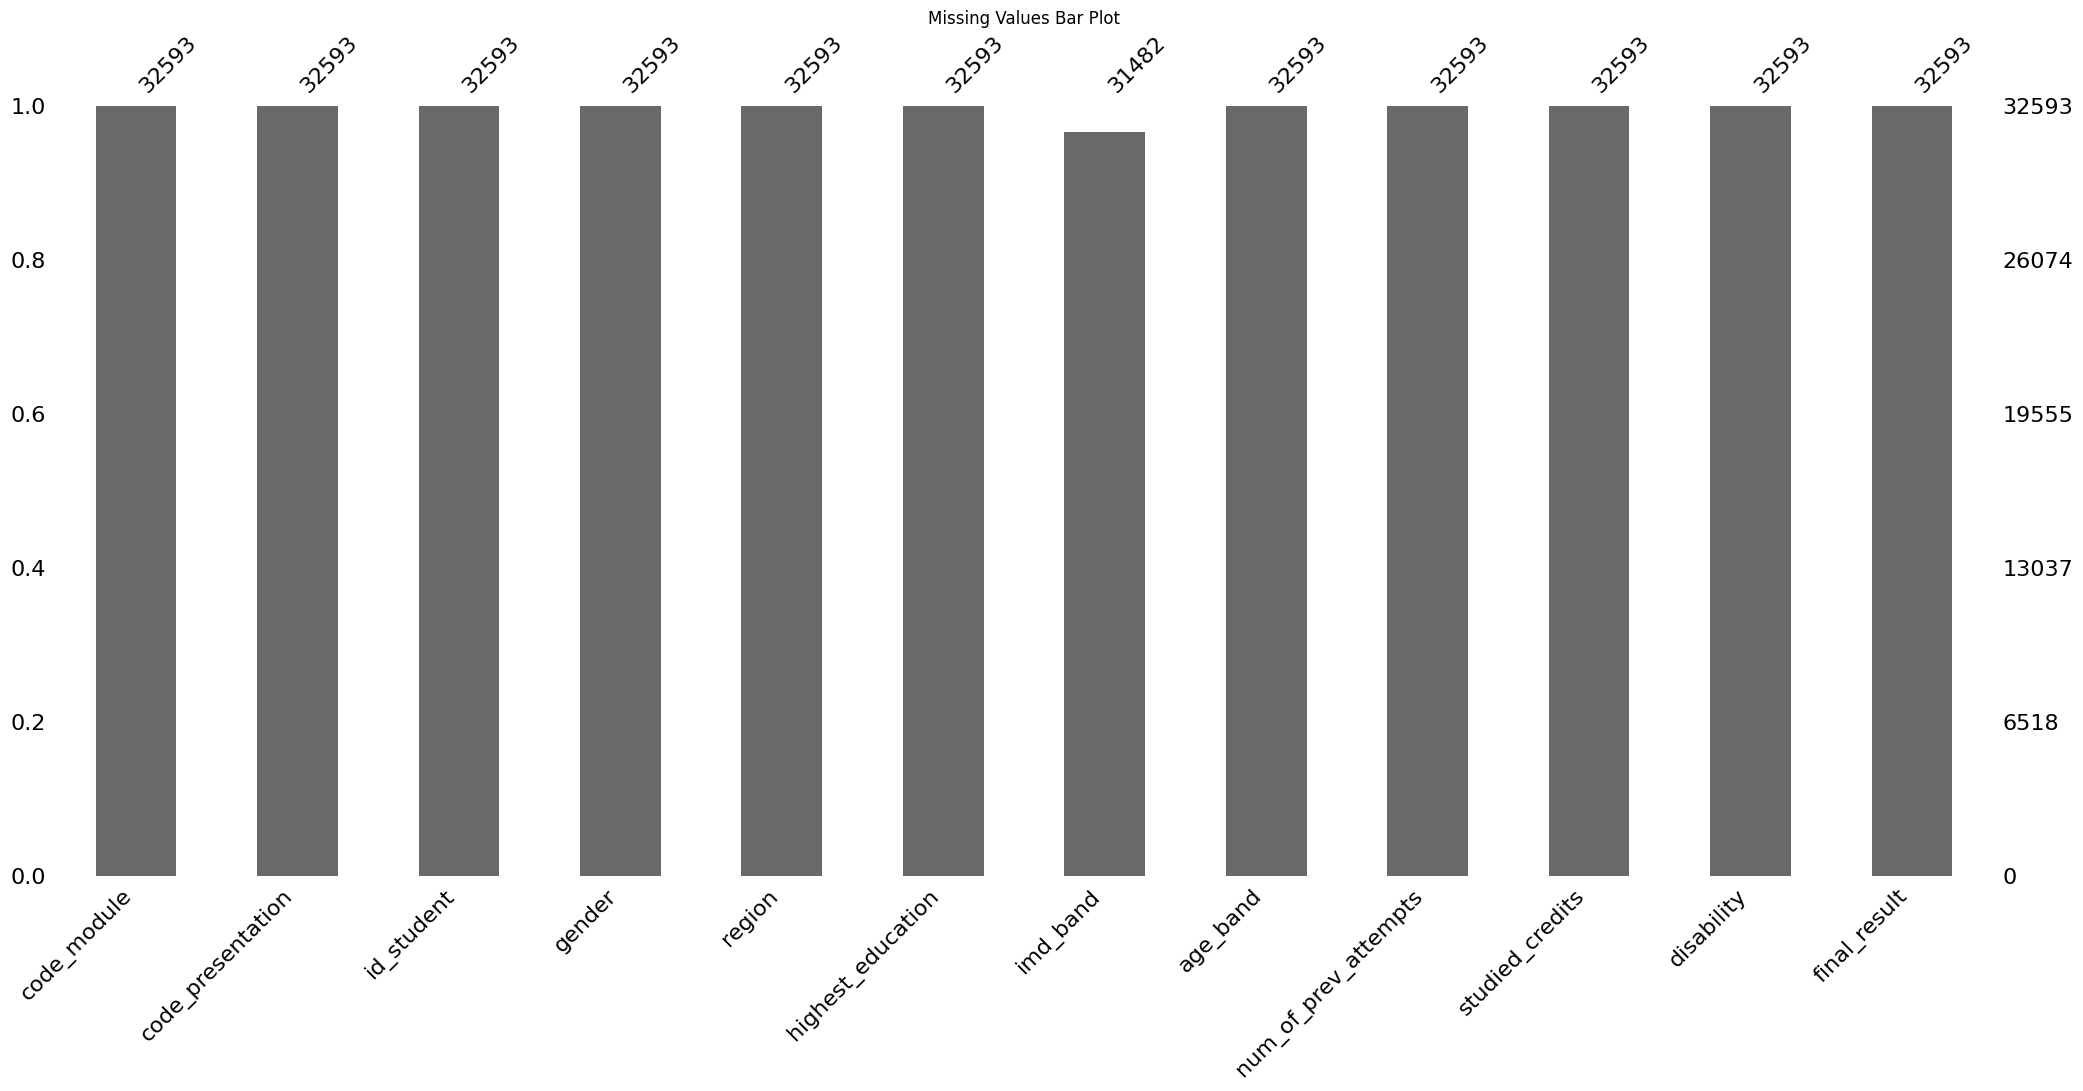

In [10]:
# Visualize missing values using a bar plot
msno.bar(oulad_studInf_df)
plt.title('Missing Values Bar Plot')
plt.show()

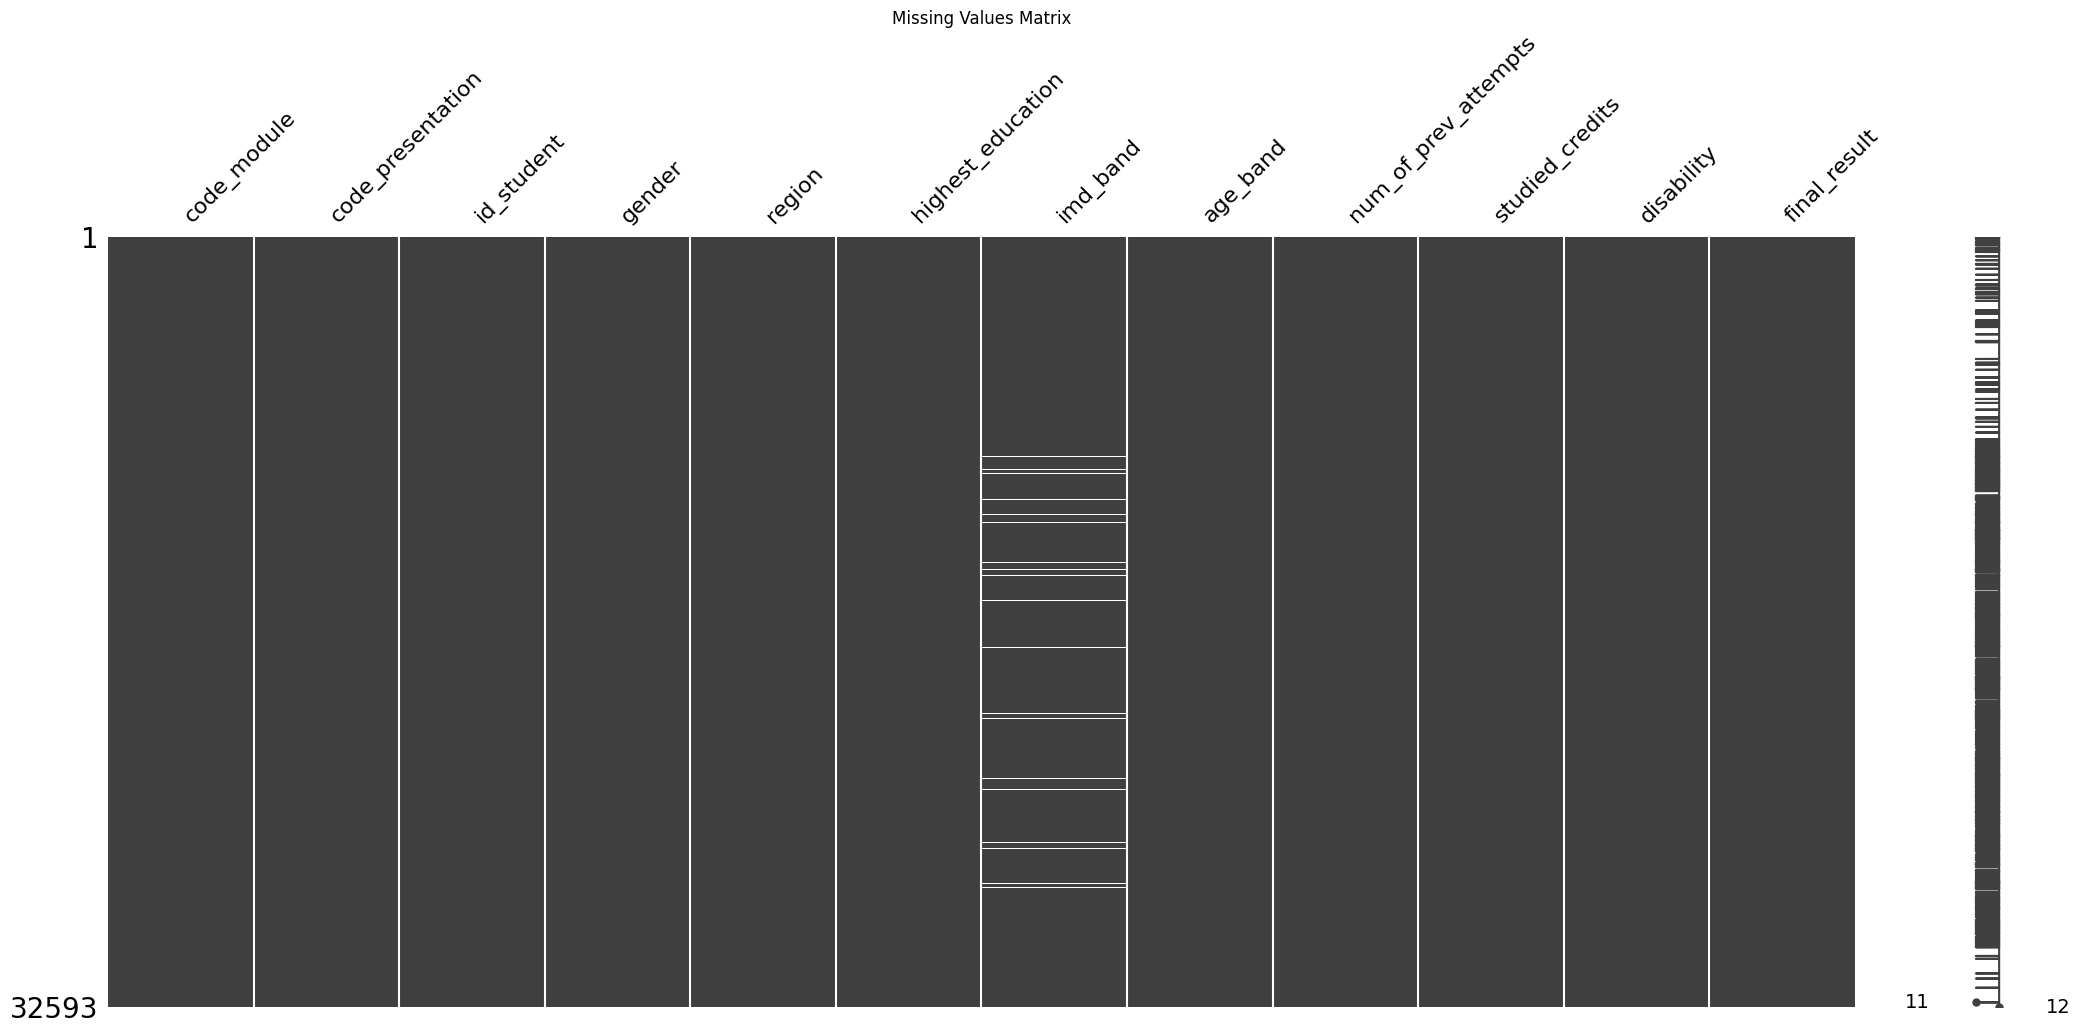

In [11]:
# Visualize missing values using a matrix plot
msno.matrix(oulad_studInf_df)
plt.title('Missing Values Matrix')
plt.show()

Imd Band includes missing values that must be handled at a later stage

<Axes: xlabel='final_result', ylabel='count'>

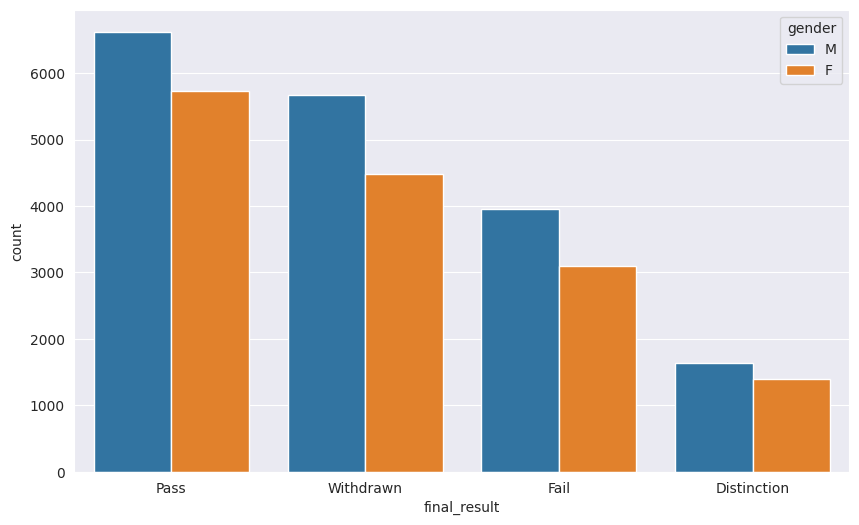

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='final_result', hue='gender', data=oulad_studInf_df.loc[:,['gender', 'final_result']])

### Probably have to deal with imbalance

<Axes: xlabel='code_module', ylabel='count'>

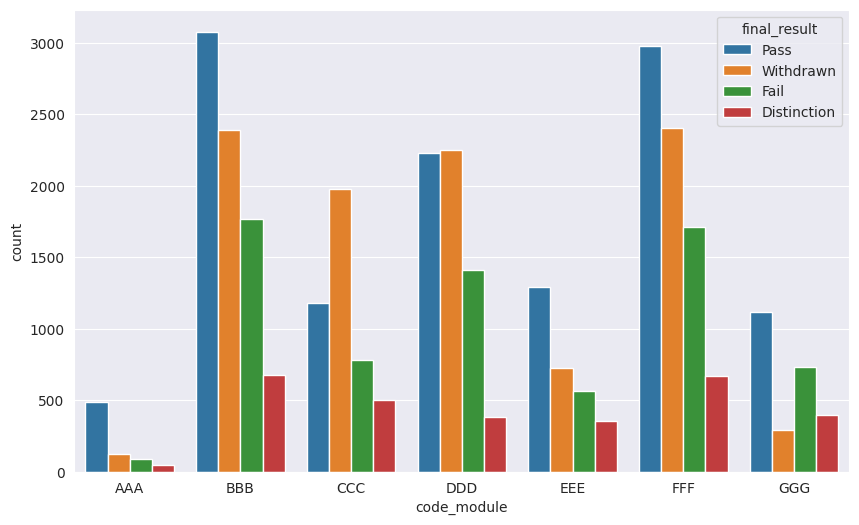

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='code_module', hue='final_result', data=oulad_studInf_df.loc[:,['code_module', 'final_result']])

In [14]:
def plot_normalized_counts(df, x_col, hue_col, count_col, plot_lines=False):
    """
    Create a bar plot with normalized counts for a given DataFrame and columns.

    Args:
        df (DataFrame): The DataFrame to use.
        x_col (str): The name of the column to use for the x-axis.
        hue_col (str): The name of the column to use for splitting the bars by hue.
        count_col (str): The name of the column to use for calculating the counts.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(20, 6))
    # Calculate the normalized counts
    counts = (df.groupby([x_col, hue_col])[count_col]
              .count()
              .unstack()
              .fillna(0))
    counts = counts.div(counts.sum(axis=1), axis=0)

    # Melt the counts dataframe to long format
    counts = counts.reset_index().melt(id_vars=x_col)

    # Create a barplot with normalized counts
    sns.barplot(x=x_col, y='value', hue=hue_col, data=counts, ax=ax)

    if plot_lines:
      unique_hue_vals = np.unique(counts.loc[:,hue_col])
      for val in unique_hue_vals:
        # Filter the counts DataFrame for each hue value
        line_data = counts.loc[counts[hue_col] == val]

        # Plot the lineplot using seaborn
        sns.lineplot(x=x_col, y='value', data=line_data, marker='o', label=f'Line for {val}', ax=ax)
      # Add a legend
      ax.legend()
      plt.show()

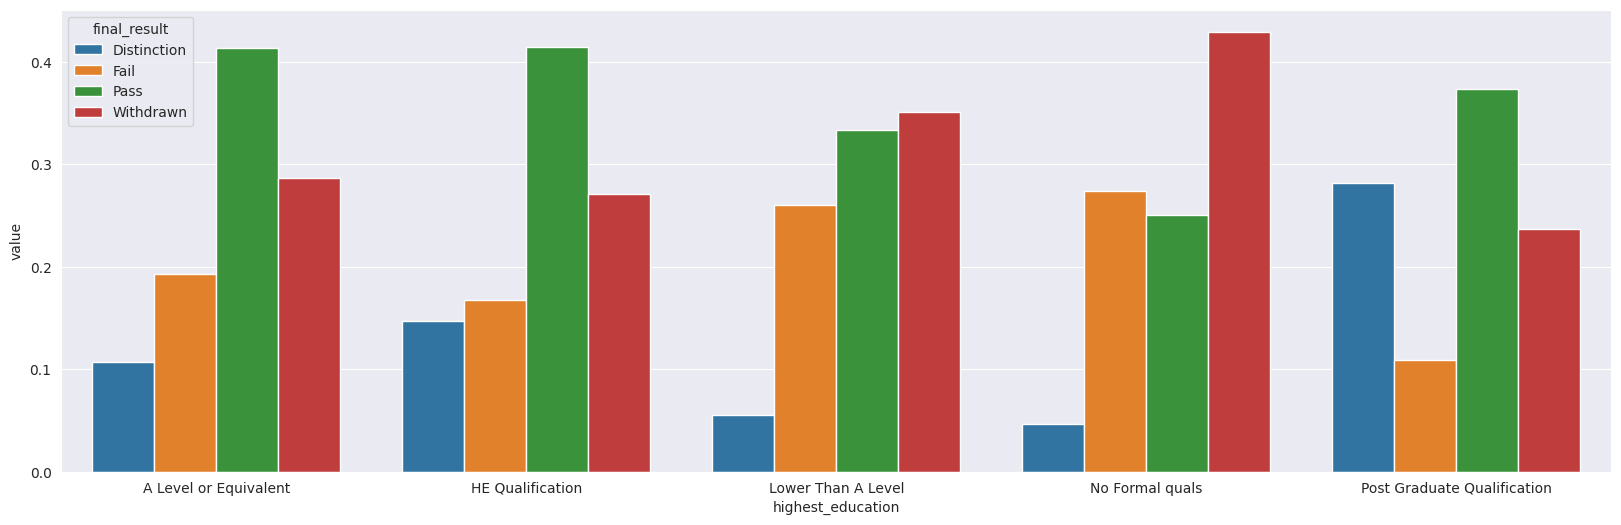

In [15]:
plot_normalized_counts(oulad_studInf_df, 'highest_education', 'final_result', 'final_result')

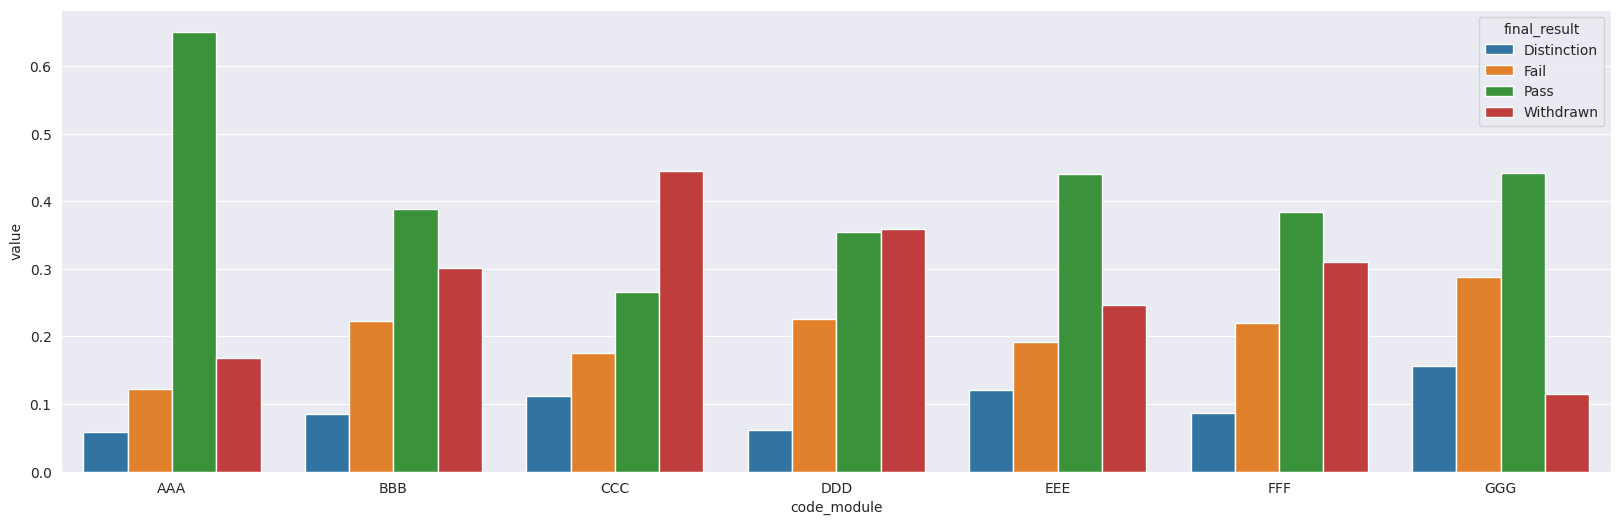

In [16]:
plot_normalized_counts(oulad_studInf_df, 'code_module', 'final_result', 'final_result')

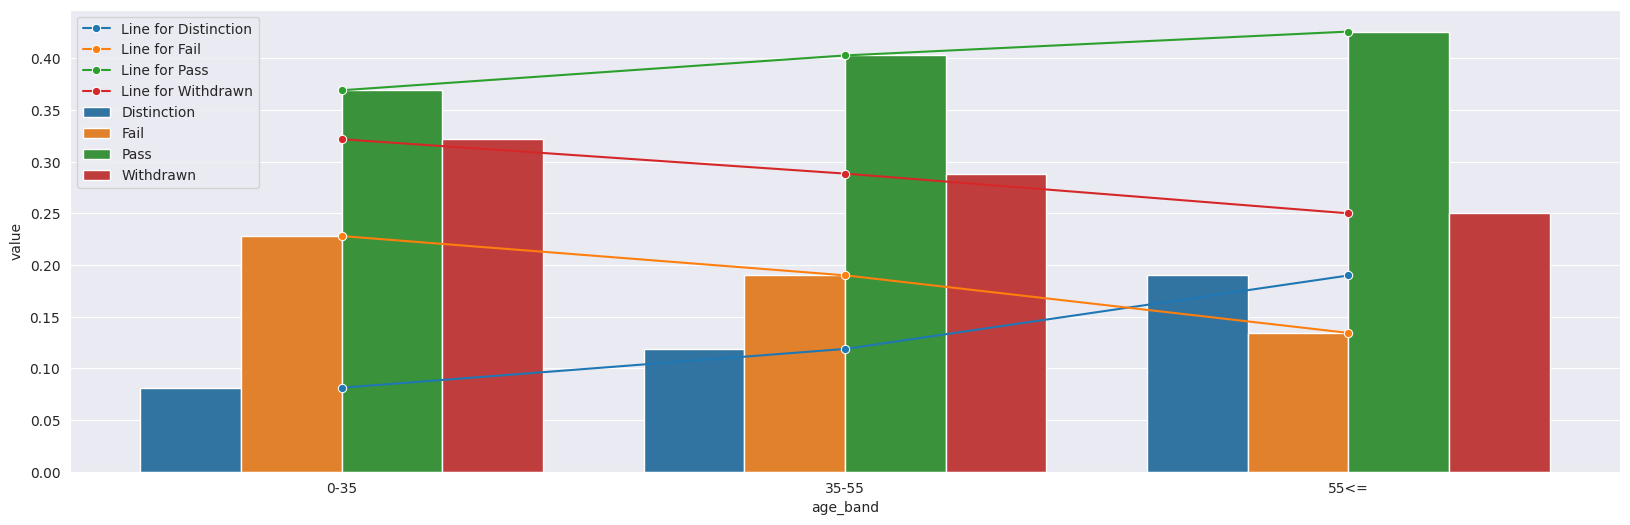

In [17]:
plot_normalized_counts(oulad_studInf_df, 'age_band', 'final_result', 'final_result', plot_lines=True)

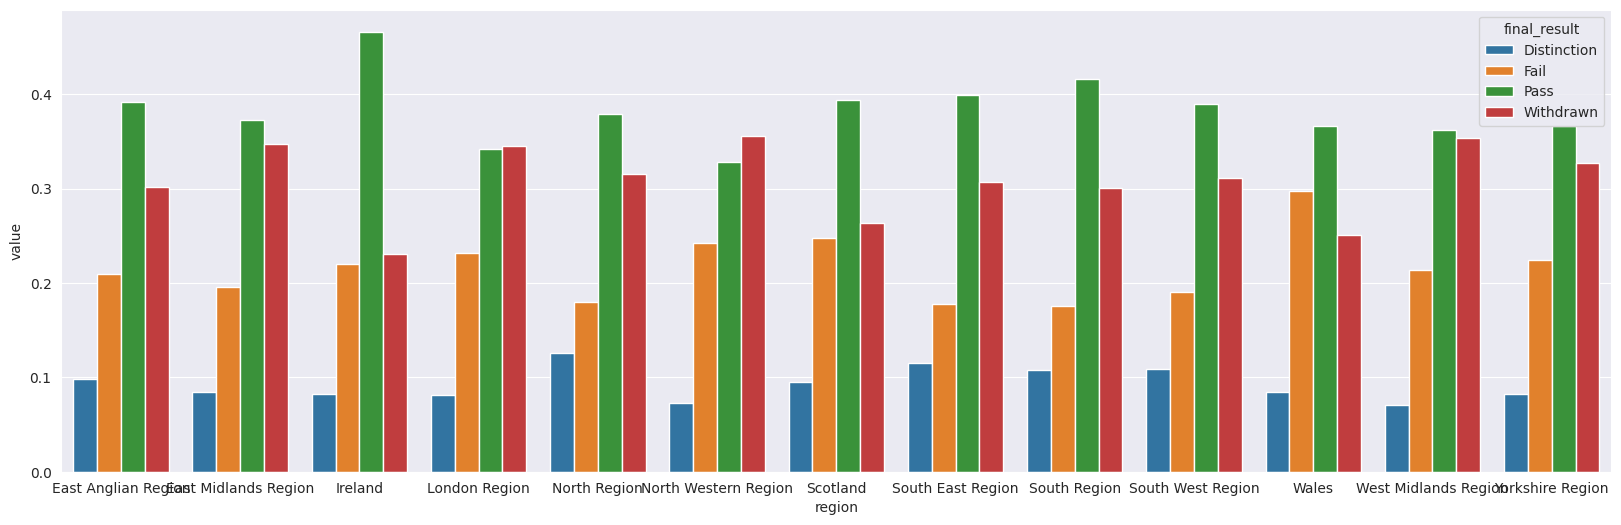

In [18]:
plot_normalized_counts(oulad_studInf_df, 'region', 'final_result', 'final_result')

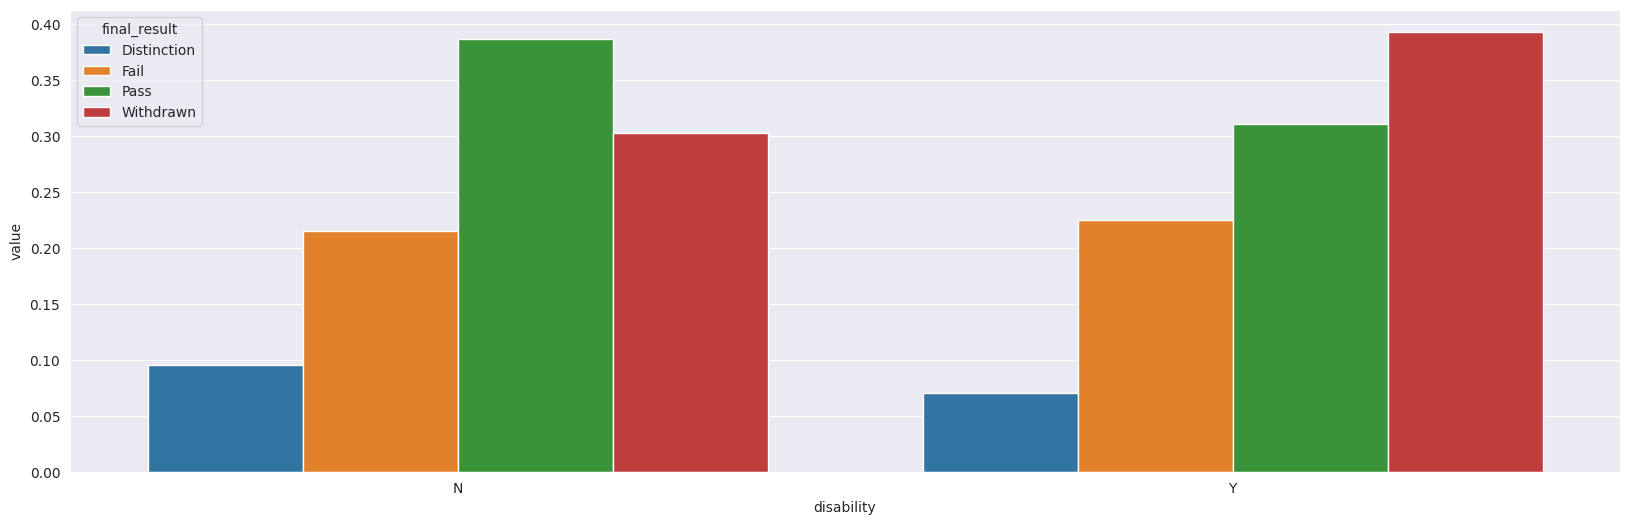

In [19]:
plot_normalized_counts(oulad_studInf_df, 'disability', 'final_result', 'final_result')

In the current English Indices of Deprivation 2019 (IoD2019) seven domains of deprivation are considered and weighted as follows,
<br>
Income. (22.5%)<br>
Employment. (22.5%)<br>
Education. (13.5%)<br>
Health. (13.5%)<br>
Crime. (9.3%)<br>
Barriers to Housing and Services. (9.3%)<br>
Living Environment. (9.3%)<br>

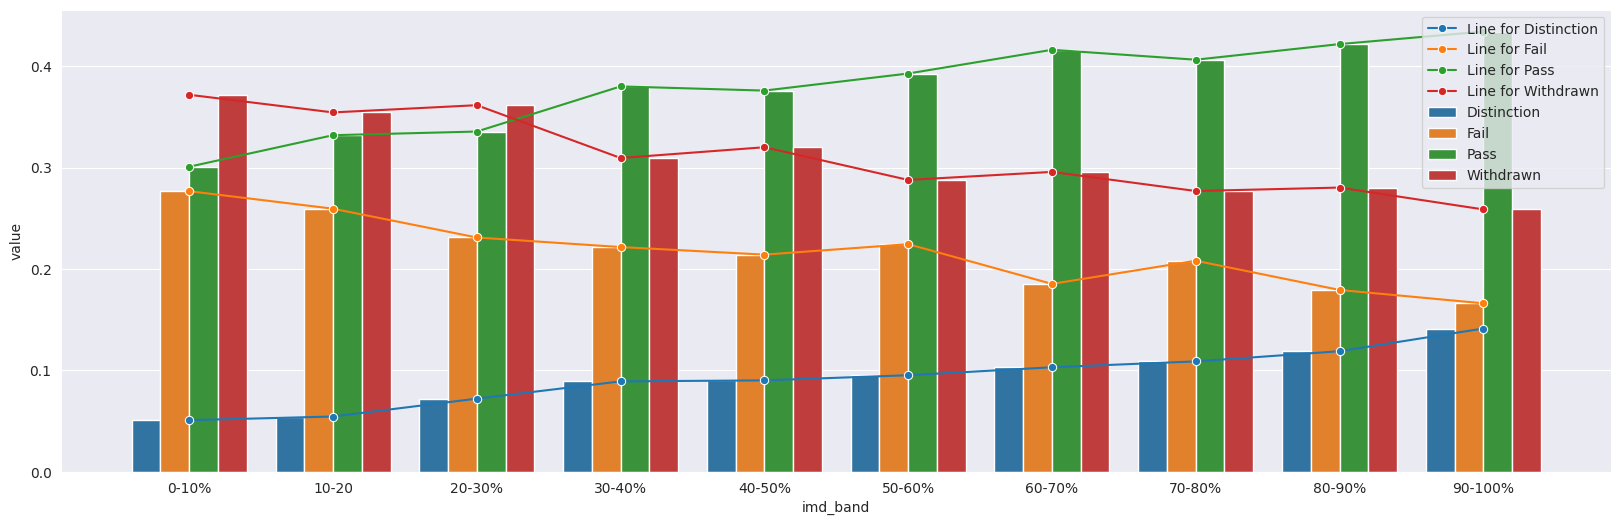

In [20]:
# (essentially a measure of poverty)
plot_normalized_counts(oulad_studInf_df, 'imd_band', 'final_result', 'final_result', plot_lines=True)

<Axes: xlabel='studied_credits', ylabel='final_result'>

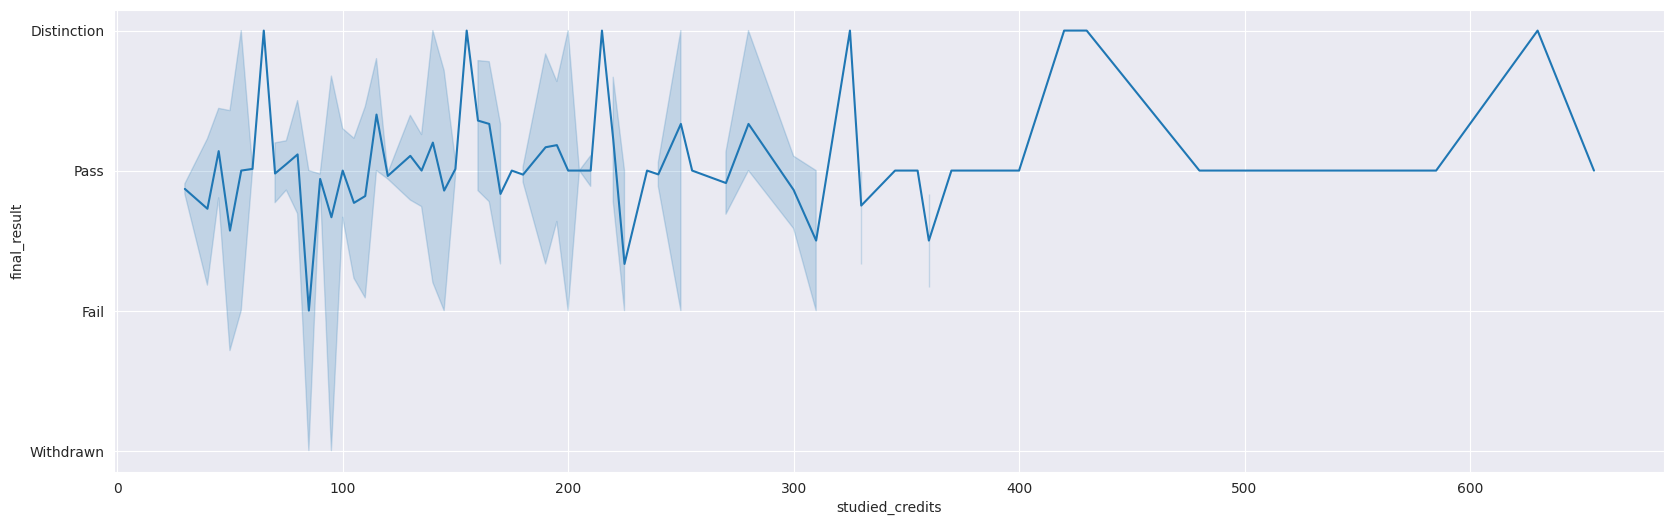

In [21]:
plt.figure(figsize=(20,6))
order = ['Distinction', 'Pass', 'Fail', 'Withdrawn']
plt.yticks(np.arange(len(order)), order)
sns.lineplot(x='studied_credits', y='final_result', data=oulad_studInf_df, hue_order=order)

# Preprocessing

In [22]:
oulad_studInf_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [23]:
oulad_studAssess_df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [24]:
# Sort the DataFrame by 'date_submitted' column in ascending order
df_sorted = oulad_studAssess_df.sort_values('date_submitted').copy()

# Keep only the first occurrence of each student ID in the given DataFrame
df_given_first_assessment = df_sorted.drop_duplicates(subset='id_student')

Taking the assumption that prediction is performed after the first assignment of the student as most of the past literature performed similar experiments.

Also including one assessment might make our models better at the prediction. (Or just make it biased towards the first assignment :) )

In [25]:
df_given_first_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
28783,15008,559381,-11,0,63.0
76237,25348,2472145,-10,0,85.0
15866,14996,610700,-9,0,75.0
109993,34865,520187,-8,0,77.0
111134,34866,529566,-8,0,84.0


In [26]:
prepro_df = oulad_studInf_df.merge(df_given_first_assessment, left_on='id_student', right_on='id_student')
prepro_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_assessment,date_submitted,is_banked,score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,1752,18,0,78.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1752,22,0,70.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,1752,17,0,72.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1752,26,0,69.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,1752,19,0,79.0


In [27]:
# Set the column type to string
prepro_df['imd_band'] = prepro_df['imd_band'].astype(str)

In [28]:
# Define the dictionary mapping qualifications to numbers
qualification_order = {
    'Post Graduate Qualification': 1,
    'HE Qualification': 2,
    'A Level or Equivalent': 3,
    'Lower Than A Level': 4,
    'No Formal quals': 5
}

age_order = {
    '0-35': 1,
    '35-55': 2,
    '55<=': 3
}

imd_band_order = {
    '0-10%': 1, 
    '10-20': 2, 
    '20-30%': 3, 
    '30-40%': 4, 
    '40-50%': 5, 
    '50-60%': 6, 
    '60-70%': 7, 
    '70-80%': 8, 
    '80-90%': 9, 
    '90-100%': 10, 
    'nan': np.nan
}

final_result_order = {
    'Distinction': 1,
    'Pass': 1,
    'Withdrawn': 0,
    'Fail': 0
}

# Replace the column values according to the dictionary keys
prepro_df['highest_education'] = prepro_df['highest_education'].replace(qualification_order)
prepro_df['age_band'] = prepro_df['age_band'].replace(age_order)
prepro_df['imd_band'] = prepro_df['imd_band'].replace(imd_band_order)
prepro_df['final_result'] = prepro_df['final_result'].replace(final_result_order)
prepro_df.head(10)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_assessment,date_submitted,is_banked,score
0,AAA,2013J,11391,M,East Anglian Region,2,10.0,3,0,240,N,1,1752,18,0,78.0
1,AAA,2013J,28400,F,Scotland,2,3.0,2,0,60,N,1,1752,22,0,70.0
2,AAA,2013J,31604,F,South East Region,3,6.0,2,0,60,N,1,1752,17,0,72.0
3,AAA,2013J,32885,F,West Midlands Region,4,6.0,1,0,60,N,1,1752,26,0,69.0
4,AAA,2013J,38053,M,Wales,3,9.0,2,0,60,N,1,1752,19,0,79.0
5,AAA,2013J,45462,M,Scotland,2,4.0,1,0,60,N,1,1752,20,0,70.0
6,AAA,2013J,45642,F,North Western Region,3,10.0,1,0,120,N,1,1752,18,0,72.0
7,AAA,2013J,52130,F,East Anglian Region,3,8.0,1,0,90,N,1,1752,19,0,72.0
8,AAA,2013J,53025,M,North Region,1,NaN,3,0,60,N,1,1752,9,0,71.0
9,AAA,2013J,57506,M,South Region,4,8.0,2,0,60,N,1,1752,18,0,68.0


In [29]:
# remove unnecessary columns [id_student, id_assessment]
prepro_df = prepro_df.drop(columns=['id_student', 'id_assessment'])

# Remove 22 rows with NaNs in 'scores' column as those students didn't perform any assessments.
prepro_df = prepro_df.dropna(subset=['score'])

In [30]:
# Perform One Hot Encoding to columns [code_module, code_presentation, gender, disability, region]
prepro_df = pd.get_dummies(prepro_df, columns=['code_module', 'code_presentation', 'gender', 'disability', 'region'])

In [31]:
prepro_df

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,final_result,date_submitted,is_banked,score,code_module_AAA,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
0,2,10.0,3,0,240,1,18,0,78.0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,3.0,2,0,60,1,22,0,70.0,1,...,0,0,0,1,0,0,0,0,0,0
2,3,6.0,2,0,60,1,17,0,72.0,1,...,0,0,0,0,1,0,0,0,0,0
3,4,6.0,1,0,60,1,26,0,69.0,1,...,0,0,0,0,0,0,0,0,1,0
4,3,9.0,2,0,60,1,19,0,79.0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26741,3,9.0,1,0,30,1,60,0,80.0,0,...,0,0,0,1,0,0,0,0,0,0
26742,4,5.0,2,0,30,1,68,0,80.0,0,...,0,0,0,0,0,0,0,0,0,0
26743,3,3.0,1,0,30,1,50,0,65.0,0,...,0,0,0,0,0,1,0,0,0,0
26744,4,10.0,2,0,30,0,56,0,83.0,0,...,0,0,0,0,1,0,0,0,0,0


### Performing Split of data at this point to perform feature encodings clusterings etc by fitting only on the training data

In [32]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(prepro_df.drop(columns=['final_result']), prepro_df['final_result'], test_size=0.2, random_state=42)

In [33]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()

## Fit and transform train data

In [34]:
# Perform K-Modes clustering
km_fillna = KMeans(n_clusters=10, init='k-means++', n_init=5)
km_fillna.fit(X_train.drop(columns=['imd_band']))

# Replace missing values with the mode of each cluster
X_train.loc[X_train['imd_band'].isna(),'imd_band'] = km_fillna.predict(X_train.loc[X_train['imd_band'].isna()].drop(columns=['imd_band']))

# Fit clustering model on training data to fill na values in imd_band column
km_feature = KMeans(n_clusters=5, init='k-means++', n_init=5)
clusters_feature = km_feature.fit_predict(X_train)
X_train['cluster_feature'] = clusters_feature

In [35]:
X_train

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,date_submitted,is_banked,score,code_module_AAA,code_module_BBB,...,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,cluster_feature
26502,4,7.0,1,0,30,61,0,45.0,0,0,...,0,0,0,0,1,0,0,0,0,3
24741,4,6.0,1,0,30,72,0,70.0,0,0,...,0,0,0,0,0,0,0,0,1,3
21715,4,7.0,1,0,180,5,0,86.0,0,0,...,0,0,0,0,0,0,0,0,0,1
11029,4,9.0,2,0,60,19,0,96.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3434,3,3.0,1,0,60,25,0,67.0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21601,3,3.0,2,0,60,16,0,72.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5396,3,5.0,2,0,60,15,0,1.0,0,1,...,0,0,0,0,1,0,0,0,0,4
861,3,2.0,1,2,300,18,0,65.0,0,1,...,0,0,0,0,0,0,0,0,0,1
15811,4,10.0,1,0,120,24,0,72.0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Transform test data

In [36]:
# Replace missing values with the mode of each cluster
X_test.loc[X_test['imd_band'].isna(),'imd_band'] = km_fillna.predict(X_test.loc[X_test['imd_band'].isna()].drop(columns=['imd_band']))

In [37]:
# Transform clustering model on training data to fill na values in imd_band column
X_test['cluster_feature'] = km_feature.predict(X_test)

# Perform Default Baseline Predictions

In [38]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Support Vector Machine': SVC(random_state=42),
        'Gaussian Naive Bayes': GaussianNB(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Multi-Layer Perceptron': MLPClassifier(random_state=42),
        'Light GBM ': lgb.LGBMClassifier(random_state=42)
        # Add more models as needed
    }

    model_results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        model_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'model_object': model
        }

        print(f"Model: {model_name}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1)
        print("Confusion Matrix:")
        print(cm)
        print("----------------------------------")

        # Create a DataFrame from the confusion matrix
        cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

        # Create a heatmap of the confusion matrix
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    return model_results


Model: Logistic Regression
Accuracy: 0.6909975669099757
Precision: 0.7000554938956715
Recall: 0.8157129000969933
F1-Score: 0.7534717037479469
Confusion Matrix:
[[1169 1081]
 [ 570 2523]]
----------------------------------


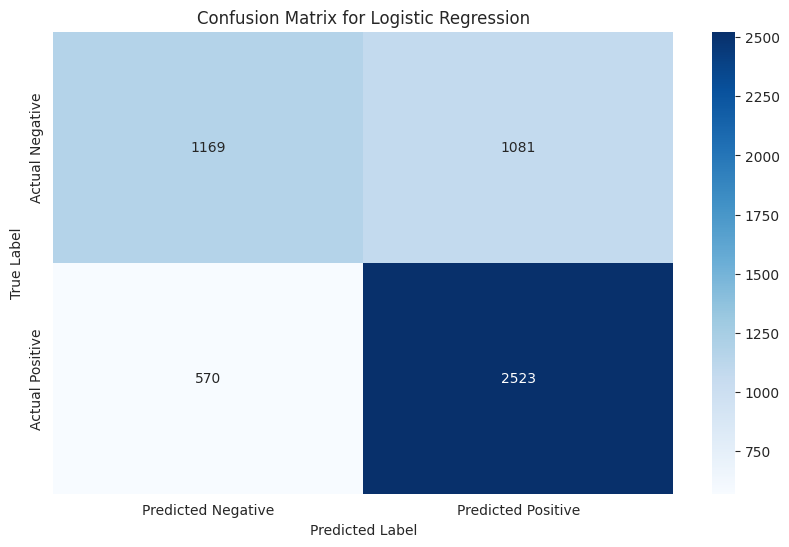

Model: Random Forest
Accuracy: 0.696612390043047
Precision: 0.7215532811559302
Recall: 0.7749757516973812
F1-Score: 0.747310989867498
Confusion Matrix:
[[1325  925]
 [ 696 2397]]
----------------------------------


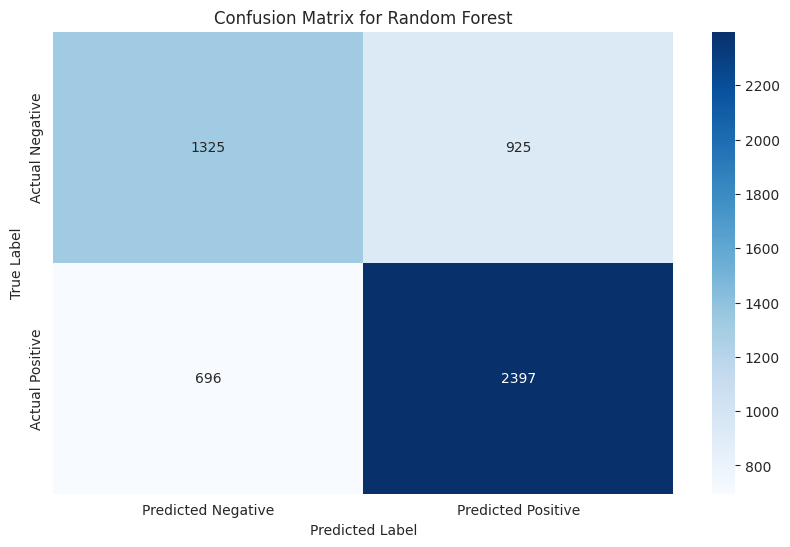

Model: Gradient Boosting
Accuracy: 0.7089650009358038
Precision: 0.7113798790544255
Recall: 0.8367280956999676
F1-Score: 0.7689793492794532
Confusion Matrix:
[[1200 1050]
 [ 505 2588]]
----------------------------------


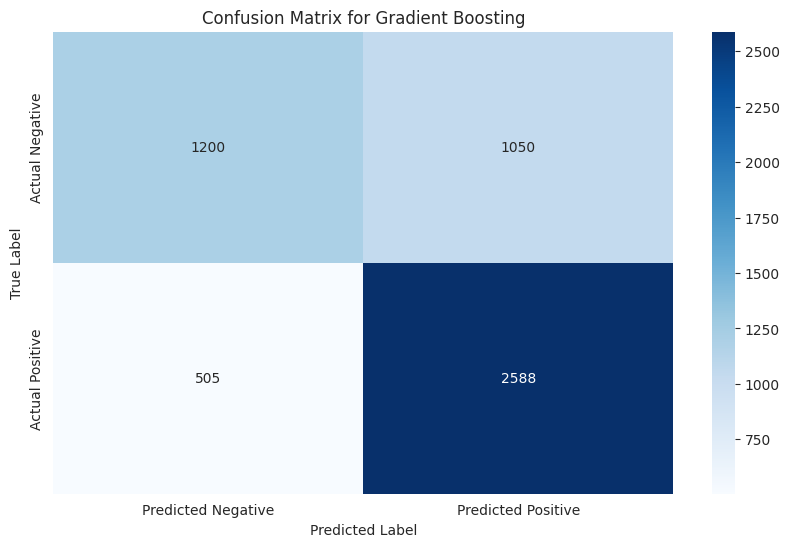

Model: Decision Tree
Accuracy: 0.6185663484933558
Precision: 0.6781492738939547
Recall: 0.6492078887811187
F1-Score: 0.6633630657416584
Confusion Matrix:
[[1297  953]
 [1085 2008]]
----------------------------------


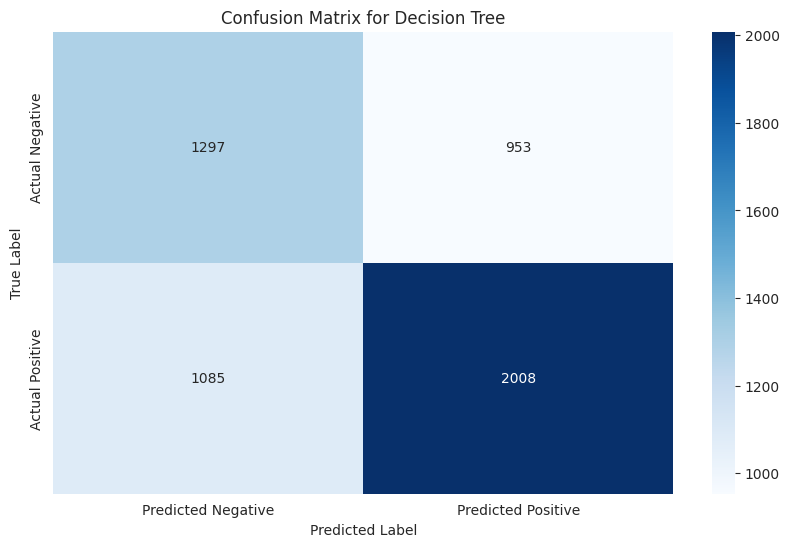

Model: K-Nearest Neighbors
Accuracy: 0.6449560172187909
Precision: 0.6852540272614622
Recall: 0.7151632719043001
F1-Score: 0.6998892580287929
Confusion Matrix:
[[1234 1016]
 [ 881 2212]]
----------------------------------


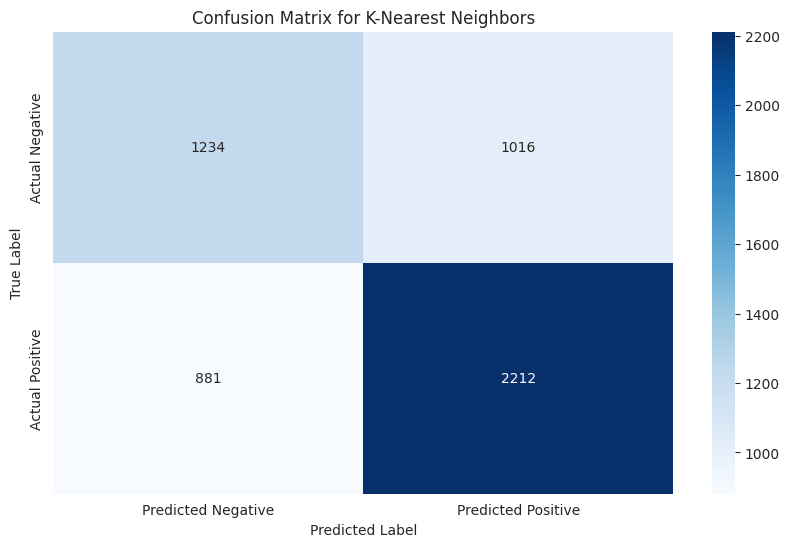

Model: Support Vector Machine
Accuracy: 0.6485120718697361
Precision: 0.6501111934766494
Recall: 0.8506304558680893
F1-Score: 0.7369747899159665
Confusion Matrix:
[[ 834 1416]
 [ 462 2631]]
----------------------------------


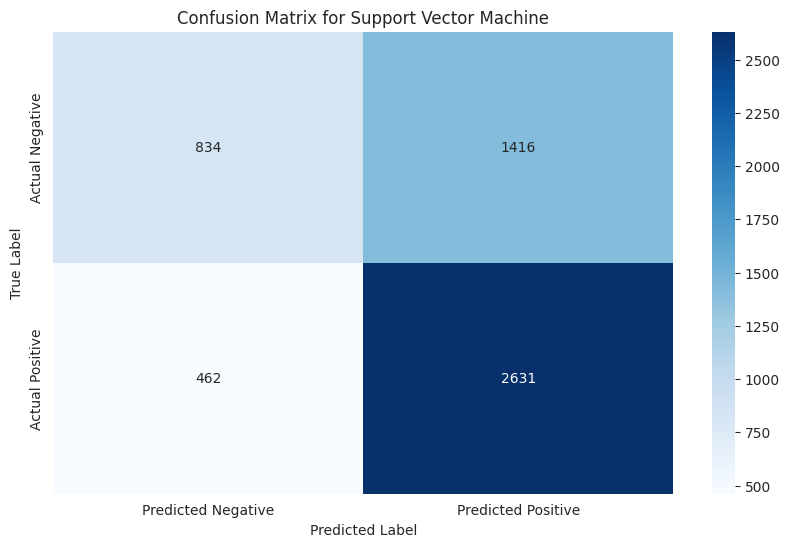

Model: Gaussian Naive Bayes
Accuracy: 0.6391540333146173
Precision: 0.6636695701039618
Recall: 0.7636598771419334
F1-Score: 0.7101623571858087
Confusion Matrix:
[[1053 1197]
 [ 731 2362]]
----------------------------------


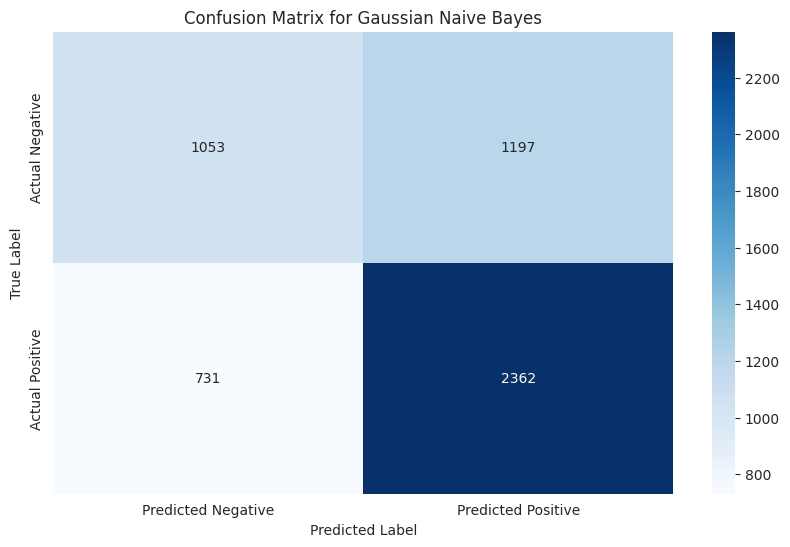

Model: Linear Discriminant Analysis
Accuracy: 0.686692869174621
Precision: 0.694011484823626
Recall: 0.8205625606207565
F1-Score: 0.752
Confusion Matrix:
[[1131 1119]
 [ 555 2538]]
----------------------------------


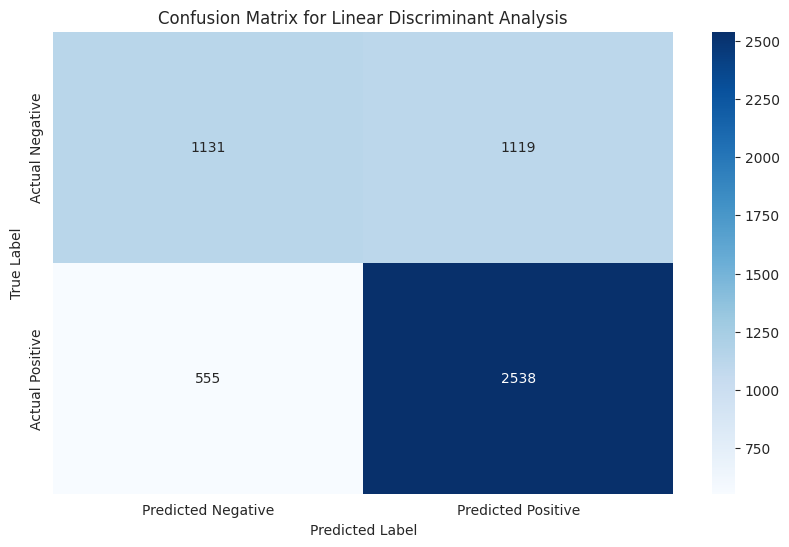

Model: Multi-Layer Perceptron
Accuracy: 0.7027886954894255
Precision: 0.7200935946183095
Recall: 0.7959909473003557
F1-Score: 0.7561425061425061
Confusion Matrix:
[[1293  957]
 [ 631 2462]]
----------------------------------


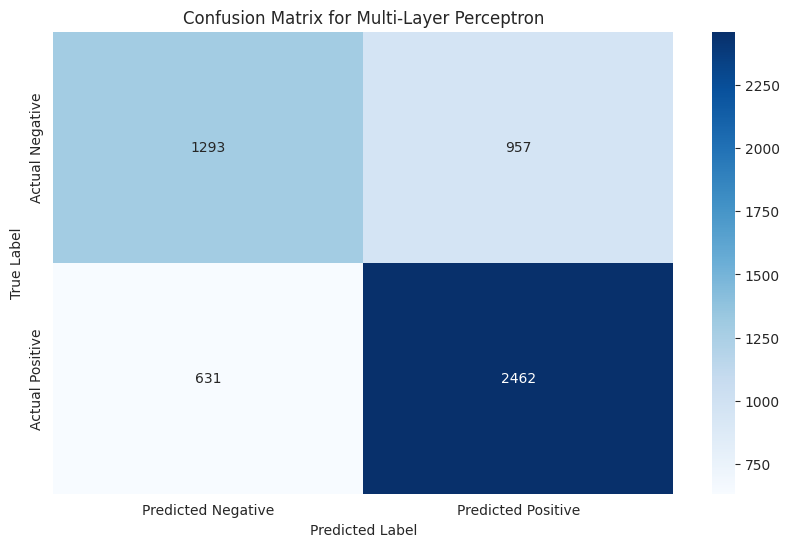

Model: Light GBM 
Accuracy: 0.7069062324536777
Precision: 0.71733561058924
Recall: 0.8147429679922406
F1-Score: 0.7629427792915532
Confusion Matrix:
[[1257  993]
 [ 573 2520]]
----------------------------------


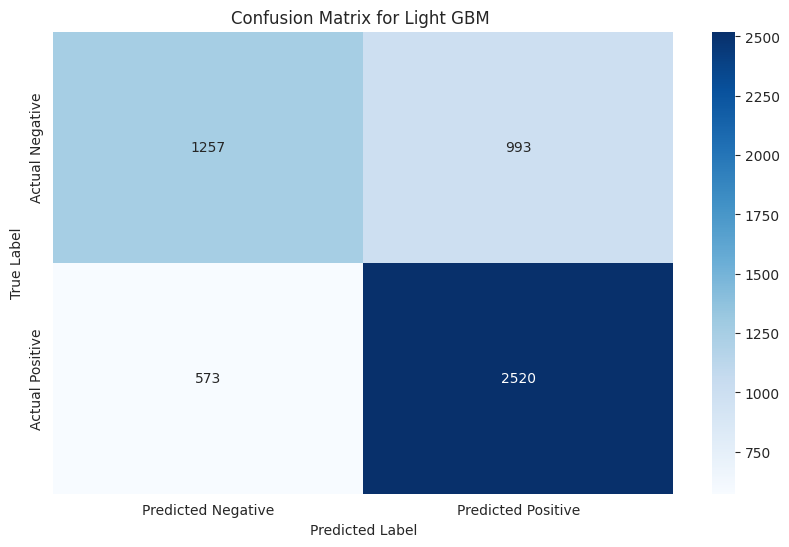

In [39]:
model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

In [40]:
model_results

{'Logistic Regression': {'accuracy': 0.6909975669099757,
  'precision': 0.7000554938956715,
  'recall': 0.8157129000969933,
  'f1': 0.7534717037479469,
  'confusion_matrix': array([[1169, 1081],
         [ 570, 2523]]),
  'model_object': LogisticRegression(max_iter=1000, random_state=42)},
 'Random Forest': {'accuracy': 0.696612390043047,
  'precision': 0.7215532811559302,
  'recall': 0.7749757516973812,
  'f1': 0.747310989867498,
  'confusion_matrix': array([[1325,  925],
         [ 696, 2397]]),
  'model_object': RandomForestClassifier(random_state=42)},
 'Gradient Boosting': {'accuracy': 0.7089650009358038,
  'precision': 0.7113798790544255,
  'recall': 0.8367280956999676,
  'f1': 0.7689793492794532,
  'confusion_matrix': array([[1200, 1050],
         [ 505, 2588]]),
  'model_object': GradientBoostingClassifier(random_state=42)},
 'Decision Tree': {'accuracy': 0.6185663484933558,
  'precision': 0.6781492738939547,
  'recall': 0.6492078887811187,
  'f1': 0.6633630657416584,
  'confus

In [41]:
def findHighestMetricModels(dict, metric, top_n):
  """
    Finds the models with the highest value for a given metric in a dictionary.

    Args:
        dictionary (dict): A dictionary containing model information.
        metric (str): The metric to use for ranking the models.
        top_n (int): The number of top models to retrieve.

    Returns:
        None

    """
  # Sort the models based on their F1 accuracy
  sorted_models = sorted(dict.items(), key=lambda x: x[1][metric], reverse=True)

  # Get the top two models with highest F1 accuracy
  top_models = sorted_models[:top_n]

  # Print the top two models
  for model_name, model_info in top_models:
      print(model_name)
      print("F1 Accuracy:", model_info['f1'])
      print("Confusion Matrix:", model_info['confusion_matrix'])
      print("Model Object:", model_info['model_object'])
      print()
  return top_models

top_models = findHighestMetricModels(model_results, 'f1', 5)

Gradient Boosting
F1 Accuracy: 0.7689793492794532
Confusion Matrix: [[1200 1050]
 [ 505 2588]]
Model Object: GradientBoostingClassifier(random_state=42)

Light GBM 
F1 Accuracy: 0.7629427792915532
Confusion Matrix: [[1257  993]
 [ 573 2520]]
Model Object: LGBMClassifier(random_state=42)

Multi-Layer Perceptron
F1 Accuracy: 0.7561425061425061
Confusion Matrix: [[1293  957]
 [ 631 2462]]
Model Object: MLPClassifier(random_state=42)

Logistic Regression
F1 Accuracy: 0.7534717037479469
Confusion Matrix: [[1169 1081]
 [ 570 2523]]
Model Object: LogisticRegression(max_iter=1000, random_state=42)

Linear Discriminant Analysis
F1 Accuracy: 0.752
Confusion Matrix: [[1131 1119]
 [ 555 2538]]
Model Object: LinearDiscriminantAnalysis()



# TODO 

- ## Handle Imbalance in target class
- ## Use cost function for training. We want to be better predicting the students who will fail
- ## Extract Shapley Values to interpret the predictions the model is making

# Cost Matrix and Cost Minimization

What we are interested in is identifying actual students which are failing their classes. So the focus should shift towards this objective.

Best baseline predictions based on f1: [κείμενο συνδέσμου](https://)

In [42]:
# Set Cost Matrix
cost_mat = [[0,3],
            [1,0]]

In [43]:
# Define functions for each model
def cost_helper(y_test, y_pred):
  """
  Computes the cost of predictions based on a confusion matrix and a cost matrix.

  Args:
      y_test (array-like): True labels of the test set.
      y_pred (array-like): Predicted labels of the test set.

  Returns:
      float: Total cost of the predictions.
  """
  conf_m = confusion_matrix(y_test, y_pred)
  

  # Print the percentage of non detected failed students
  non_detected_failures = conf_m[0,1]
  detected_failures = conf_m[0,0]
  total_vals = non_detected_failures + detected_failures
  percentage = (non_detected_failures / total_vals) * 100
  print(f'Percentage of non detected failed students: {percentage} % (from all actual failed students)')

  cost = np.sum(conf_m * cost_mat)
  # For debugging purposes
  print("Confusion Matrix")
  print(conf_m)
  return cost

def cost_minimizer(y_pred_prob):
  """
  This function takes in predicted probabilities and returns predicted labels based on a cost matrix.

  Parameters:
      y_pred_prob (numpy.ndarray): Predicted probabilities.

  Returns:
      numpy.ndarray: Predicted labels based on a cost matrix.
  """
  y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_mat)), axis=1)
  # Add one to correspond to X_test for confusion matrix
  # y_pred += 1
  return y_pred

def under_sample(X_train, y_train):
  """
  Undersamples the training data using the RandomUnderSampler.

  Args:
      X_train (array-like): The input features of the training data.
      y_train (array-like): The target labels of the training data.

  Returns:
      X_resampled (array-like): The undersampled features.
      y_resampled (array-like): The undersampled target labels.

  """
  # Create an instance of the RandomUnderSampler class
  rus = RandomUnderSampler(random_state=42)
  # Use the fit_resample method of the RandomUnderSampler class to undersample the dataframe
  X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

  return X_resampled, y_resampled

def over_sample(X_train, y_train):
  """
  Oversamples the training data using the SMOTENC.

  Args:
      X_train (array-like): The input features of the training data.
      y_train (array-like): The target labels of the training data.

  Returns:
      X_resampled (array-like): The undersampled features.
      y_resampled (array-like): The undersampled target labels.

  """
  # Create an instance of the SMOTE class
  smotenc = SMOTE(random_state=42)
  # Use the fit_resample method of the RandomUnderSampler class to undersample the dataframe
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  return X_resampled, y_resampled


def model_func(model, X_train, y_train, X_test, y_test, cost_min = False, imb_opt = False, imb_opt_type = 'under'):
  """
  Trains a Linear Support Vector Machine model on the training set and evaluates it on the test set.

  Args:
      X_train (array-like): Features of the training set.
      y_train (array-like): Labels of the training set.
      X_test (array-like): Features of the test set.
      y_test (array-like): True labels of the test set.

  Returns:
      float: Total cost of the predictions.
  """
  if imb_opt and imb_opt_type=='under':
    X_train, y_train = under_sample(X_train, y_train)
  if imb_opt and imb_opt_type=='over':
    X_train, y_train = over_sample(X_train, y_train)

  model.probability = cost_min 
  model.fit(X_train, y_train)
  if cost_min:
    y_pred_prob = model.predict_proba(X_test)
    y_pred = cost_minimizer(y_pred_prob)
  else:
    y_pred = model.predict(X_test)
  return cost_helper(y_test, y_pred), model, X_train, y_train

## Cost without cost minimization

In [44]:
# Loop through each model and run its respective function
print(f'Train Set samples: {len(X_train)}')
print(f'Test Set samples: {len(X_test)}')
for model_name, model_info in top_models:
    print(f'Running {model_name}')
    cost, _, _, _ = model_func(model_info['model_object'], X_train, y_train, X_test, y_test)
    print(f'Cost: {cost}')
    print('-------------------')

Train Set samples: 21372
Test Set samples: 5343
Running Gradient Boosting
Percentage of non detected failed students: 46.666666666666664 % (from all actual failed students)
Confusion Matrix
[[1200 1050]
 [ 505 2588]]
Cost: 3655
-------------------
Running Light GBM 
Percentage of non detected failed students: 44.13333333333333 % (from all actual failed students)
Confusion Matrix
[[1257  993]
 [ 573 2520]]
Cost: 3552
-------------------
Running Multi-Layer Perceptron
Percentage of non detected failed students: 42.53333333333333 % (from all actual failed students)
Confusion Matrix
[[1293  957]
 [ 631 2462]]
Cost: 3502
-------------------
Running Logistic Regression
Percentage of non detected failed students: 48.044444444444444 % (from all actual failed students)
Confusion Matrix
[[1169 1081]
 [ 570 2523]]
Cost: 3813
-------------------
Running Linear Discriminant Analysis
Percentage of non detected failed students: 49.733333333333334 % (from all actual failed students)
Confusion Matrix
[

## Cost with cost minimization

In [45]:
# Loop through each model and run its respective function
print(f'Train Set samples: {len(X_train)}')
print(f'Test Set samples: {len(X_test)}')
for model_name, model_info in top_models:
    print(f'Running {model_name}')
    cost, _, _, _  = model_func(model_info['model_object'], X_train, y_train, X_test, y_test, cost_min=True)
    print(f'Cost: {cost}')
    print('-------------------')

Train Set samples: 21372
Test Set samples: 5343
Running Gradient Boosting
Percentage of non detected failed students: 8.755555555555555 % (from all actual failed students)
Confusion Matrix
[[2053  197]
 [2111  982]]
Cost: 2702
-------------------
Running Light GBM 
Percentage of non detected failed students: 10.755555555555556 % (from all actual failed students)
Confusion Matrix
[[2008  242]
 [1888 1205]]
Cost: 2614
-------------------
Running Multi-Layer Perceptron
Percentage of non detected failed students: 8.488888888888889 % (from all actual failed students)
Confusion Matrix
[[2059  191]
 [2152  941]]
Cost: 2725
-------------------
Running Logistic Regression
Percentage of non detected failed students: 8.71111111111111 % (from all actual failed students)
Confusion Matrix
[[2054  196]
 [2222  871]]
Cost: 2810
-------------------
Running Linear Discriminant Analysis
Percentage of non detected failed students: 9.155555555555555 % (from all actual failed students)
Confusion Matrix
[[20

# Cost Minimization with Balancing data (Using Undersampling)

In [46]:
# Loop through each model and run its respective function
print(f'Train Set samples: {len(X_train)}')
print(f'Test Set samples: {len(X_test)}')
for model_name, model_info in top_models:
    print(f'Running {model_name}')
    cost, model_info['opt_model'], model_info['sampled_input_data'], model_info['sampled_target_data']= model_func(model_info['model_object'], X_train, y_train, X_test, y_test, cost_min=True, imb_opt=True)
    print(f'Cost: {cost}')
    print('-------------------')

Train Set samples: 21372
Test Set samples: 5343
Running Gradient Boosting
Percentage of non detected failed students: 2.933333333333333 % (from all actual failed students)
Confusion Matrix
[[2184   66]
 [2646  447]]
Cost: 2844
-------------------
Running Light GBM 
Percentage of non detected failed students: 5.511111111111111 % (from all actual failed students)
Confusion Matrix
[[2126  124]
 [2366  727]]
Cost: 2738
-------------------
Running Multi-Layer Perceptron
Percentage of non detected failed students: 1.7777777777777777 % (from all actual failed students)
Confusion Matrix
[[2210   40]
 [2804  289]]
Cost: 2924
-------------------
Running Logistic Regression
Percentage of non detected failed students: 4.3999999999999995 % (from all actual failed students)
Confusion Matrix
[[2151   99]
 [2641  452]]
Cost: 2938
-------------------
Running Linear Discriminant Analysis
Percentage of non detected failed students: 4.488888888888889 % (from all actual failed students)
Confusion Matrix
[[

# Cost Minimization with Balancing data (Using OverSampling)

In [47]:
# Loop through each model and run its respective function
print(f'Train Set samples: {len(X_train)}')
print(f'Test Set samples: {len(X_test)}')
for model_name, model_info in top_models:
    print(f'Running {model_name}')
    cost, _ , _, _ = model_func(model_info['model_object'], X_train, y_train, X_test, y_test, cost_min=True, imb_opt=True, imb_opt_type='over')
    print(f'Cost: {cost}')
    print('-------------------')

Train Set samples: 21372
Test Set samples: 5343
Running Gradient Boosting
Percentage of non detected failed students: 3.3333333333333335 % (from all actual failed students)
Confusion Matrix
[[2175   75]
 [2593  500]]
Cost: 2818
-------------------
Running Light GBM 
Percentage of non detected failed students: 8.755555555555555 % (from all actual failed students)
Confusion Matrix
[[2053  197]
 [2069 1024]]
Cost: 2660
-------------------
Running Multi-Layer Perceptron
Percentage of non detected failed students: 31.555555555555554 % (from all actual failed students)
Confusion Matrix
[[1540  710]
 [ 963 2130]]
Cost: 3093
-------------------
Running Logistic Regression


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Percentage of non detected failed students: 7.733333333333333 % (from all actual failed students)
Confusion Matrix
[[2076  174]
 [2283  810]]
Cost: 2805
-------------------
Running Linear Discriminant Analysis
Percentage of non detected failed students: 8.577777777777778 % (from all actual failed students)
Confusion Matrix
[[2057  193]
 [2215  878]]
Cost: 2794
-------------------


Smote didn't work as well. Will proceed with undersampling. 

### Best model in terms of cost was Light GBM. <br>
### Best model in terms of lowest percentage of non-detected failed students was MLP

In [194]:
def extract_shapley_values(model, X_train, y_train):
    """
    Extracts the Shapley values for a given model and input data.

    Args:
        model: The trained model object.
        X_train (array-like): The input features of the training data.

    Returns:
        shapley_values (array-like): The Shapley values.

    """
    model.fit(X_train, y_train)
    # Create an explainer object using the trained model
    explainer = shap.TreeExplainer(model)

    # Calculate Shapley values
    shapley_values = explainer.shap_values(X_train)

    # Extract feature importance
    feature_importance = model.feature_importances_

    train_predictions = model.predict_proba(X_train)

    return shapley_values, explainer, feature_importance, train_predictions

In [196]:
# Extract Shapley values
opt_model = top_models[1][1]['opt_model']
sampl_inp_data = top_models[1][1]['sampled_input_data']
sampl_targ_data = top_models[1][1]['sampled_target_data']
shapley_values, explainer, feat_imp, train_predictions = extract_shapley_values(opt_model, sampl_inp_data,sampl_targ_data)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [197]:
sampl_inp_data

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,date_submitted,is_banked,score,code_module_AAA,code_module_BBB,...,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,cluster_feature
0,4,6.0,1,0,30,72,0,70.0,0,0,...,0,0,0,0,0,0,0,0,1,3
1,4,7.0,1,0,180,5,0,86.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,3.0,1,0,60,25,0,67.0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,2,4.0,1,0,60,19,0,58.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2.0,1,0,120,31,0,92.0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18159,3,2.0,1,1,150,23,0,58.0,0,0,...,0,0,1,0,0,0,0,0,0,2
18160,4,2.0,1,0,60,18,0,68.0,0,1,...,0,0,0,0,0,0,0,0,0,0
18161,2,8.0,1,0,60,24,0,83.0,0,0,...,0,0,0,0,0,0,0,0,0,0
18162,2,8.0,1,0,60,9,0,86.0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [198]:
# print the JS visualization code to the notebook
shap.initjs()

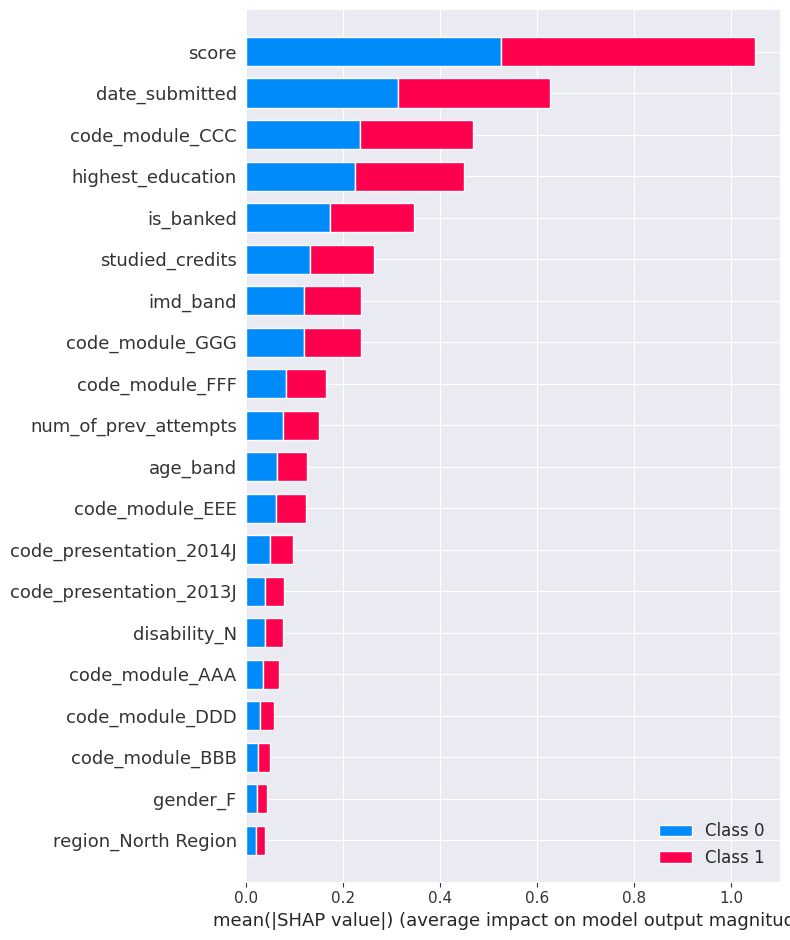

In [199]:
# Summary Plot
shap.summary_plot(shapley_values, sampl_inp_data, plot_type="bar")
plt.show()

In [207]:
# Force Plot
shap.initjs()
sample_idx = 20  # Index of the sample to visualize
shap.force_plot(explainer.expected_value[1], shapley_values[1][sample_idx, :], sampl_inp_data.iloc[sample_idx, :])

In [208]:
sampl_targ_data[sample_idx]

0

In [209]:
train_predictions[sample_idx]

array([0.44126958, 0.55873042])

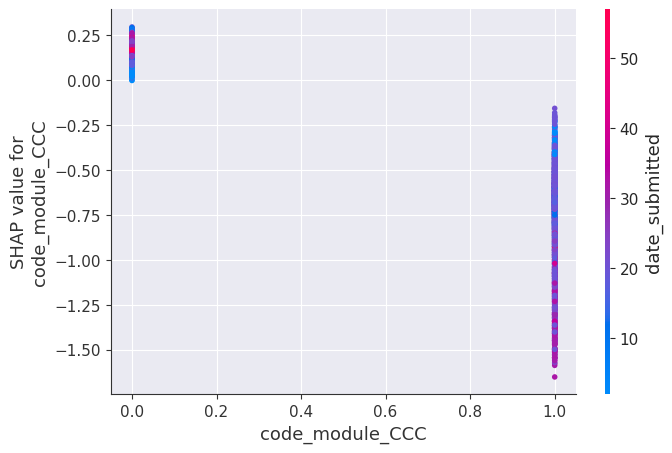

In [93]:
# Dependence Plot
feature_idx = 10  # Index of the feature to visualize
shap.dependence_plot(feature_idx, shapley_values[1], sampl_inp_data)
plt.show()